#### The Objective of this project is to evaluate LLM models' ability to understand the logical mathematical statements and respond accordingly.

It helps us understand if the LLMs are actually able to related with the statements, or just work on the probabilitic appraoch for statements which they use for next word generation.

Here I used two models, **gemma3:1b** and **gpt-oss:20b-cloud** for comparison against 3 different tones of prompts, and 3 different prompt types. 

*Further, for zero-shot prompts, I have used a custom attention based approach to evaluate capability of models by removing certain important words from the puzzle and comparing its answers. I have not performed this analysis for chain-of-thought and few-shot prompts due to restricted computational resources on my laptop and run-time of models.*

##### Part 1. Setting up Data and Prompt and running the Models using Ollama (Gemini & ChatGPT) models

In [2]:
# Importing Libraries and Setting up Data
import pandas as pd                            # library for data manipulation
import numpy as np                             # for numerical operations
import re                                      # regex
import os                                      # for os functions
import time                                    # for time
import ollama  # pip install ollama            # ollama to run ollama models locally 
import seaborn as sns                          # for plots
import matplotlib.pyplot as plt                # for plots

In [ ]:
# 1. File Loading and models used
# .......................................................................................................................................................................#
# Models Used from the Ollama model
MODELS = ["gemma3:1b", "gpt-oss:20b-cloud"] 
# gemma3:1b - Gemma 3 model with approximately 1 billion parameters. It is an ultra-lightweight, small-scale model designed for efficient local execution. 
####        - Primary application is in scenarios requiring low resource consumption, making it suitable for running on standard consumer hardware, 
####        - edge devices, or for tasks that do not demand the complexity of larger models.
# gpt-oss:20b-cloud - Open-source GPT model totaling approximately 20 billion parameters, optimized for cloud deployment.
####                - intended for more complex tasks than gemma3:1b, offering greater capacity for nuanced understanding and generation, 
####                - typically run on cloud infrastructure due to its larger parameter size.
"""
Since the models are comparativley very different the assumption is that GPT should perform better for this task and should also be able to respond better for diagnostics.
"""

# Selected Puzzle Set (This set has 6 puzzles of each category, where we will use 1 in each separately for few shot prompts) 
# FILE_PATH = r"C:\Users\Akash Mittal\Documents\GitHub\Logical_Puzzles_LLM\NLP_Project\data\Puzzles_List_6_Each.csv"
FILE_PATH = r"data\Puzzles_List_6_Each.csv"
CHECKPOINT_FILE = "eval_ollama_results.pkl"                             # outputs from model to be saved in a pickle file
CSV_CHECKPOINT = "eval_ollama_results.csv"                              # outputs saved in a csv file

# .......................................................................................................................................................................#
# 2. Loading the final data
# .......................................................................................................................................................................#
# Loading original dataset from the CSV file
original_data = pd.read_csv(FILE_PATH, index_col="id").reset_index(drop=True)  # index reset 

# Splitting the data into support and evaluation sets
groups = original_data.groupby("combo_key")               # combo key is key for "puzzle types"
eval_rows = []                                            # dataset that will be used for running the LLM models
support_rows = []                                         # dataset used for Few-shot prompting examples

# loop to split the dataset so 1 puzzle form each group is in eval_set.
for name, g in groups:
    g = g.sample(frac=1, random_state=42)                  # seed set ofr shuffling for reproducibility
    eval_rows.append(g.iloc[:5])                           # 5 puzzles in eval set
    support_rows.append(g.iloc[5:6])                       # 1 puzzzle each in support set 

eval_df = pd.concat(eval_rows).reset_index(drop=True)             # transforming data into dataframe
support_df = pd.concat(support_rows).reset_index(drop=True)       # transforming data into creating dataframe  

# Loading checkpoint .... used for resuming analysis in cases of interruption
if os.path.exists(CHECKPOINT_FILE):
    print(f"Resuming from {CHECKPOINT_FILE}...")
    eval_df = pd.read_pickle(CHECKPOINT_FILE)
else:
    print("Starting fresh...")

# Initializing the columns for each model... 3 prompts * 3 tones each...so 9 models each
prompt_types = ["zs", "fs", "cot"]                               # 3 prompt types prefixes, zs=Zero-Shot, fs=Few-Shot, cot=Chain-of-Thought
tones = ["neutral", "urgent", "high_stakes"]                     # 3 prompt tones

# looping to create columns and assigning the values
for model in MODELS:
    # cleaning the model name for column headers
    safe_model_name = model.replace(":", "_").replace("-", "_")
    
    for p in prompt_types:               # for each prompt type
        for t in tones:                  # for each prompt tone type
            # columns for answer, time taken, and raw text output
            col_ans = f"{safe_model_name}_{p}_{t}_ans"
            col_time = f"{safe_model_name}_{p}_{t}_time"
            col_raw = f"{safe_model_name}_{p}_{t}_raw"
            
            if col_ans not in eval_df.columns:                    # initializing columns with None
                eval_df[col_ans] = None
                eval_df[col_time] = None
                eval_df[col_raw] = None

# .......................................................................................................................................................................#
# 3. Prompt Builder Functions
# .......................................................................................................................................................................#
# dictionary of tone tones
TONE_VARIANTS = {
    "neutral": "Solve the puzzle clearly and choose the correct option.",
    "urgent": "This is important. Respond quickly and accurately.",
    "high_stakes": "Critical decision. Think carefully and choose the correct option."
}

# Final prompt building function sent for input of prompts to the LLM.
def build_prompt(p_type, text, question, options, tone):
    # Get the base instruction based on the requested tone
    base_inst = TONE_VARIANTS[tone]
    
    # Adding strict formatting constraints for smaller models...else they becomes noisy with outputs
    format_inst = "Return ONLY the option number. Do not explain."         # strict instruction
    
    # case 1, zero shot
    if p_type == "zs":
        # combining instructions, puzzle text, question, and the options.
        return f"{base_inst} {format_inst}\n\nPuzzle:\n{text}\n\nQuestion:\n{question}\n\nOptions:\n{options}\n\nAnswer:"
    
    # case 2, few-shot analysis
    elif p_type == "fs":
        examples = ""
        # Iterate through the support_df (support_df has 1 puzzle per category).
        for _, row in support_df.iterrows():
            # formatting the support row into a Q&A example string
            examples += f"Example:\n{row['text']}\nQuestion: {row['question']}\nOptions: {row['options']}\nAnswer: {row['answer']}\n\n"
        # appending the examples before the new puzzle.
        return f"{base_inst} {format_inst}\n\n{examples}Now solve this:\n\nPuzzle:\n{text}\n\nQuestion:\n{question}\n\nOptions:\n{options}\n\nAnswer:"
    
    # case 3, chain-of-thought (CoT) for step-by-step reasoning.
    elif p_type == "cot":
        # detailed reasoning strategy block.
        strat = """General Reasoning Strategy:
        1. Identify the core question being asked (what must be found?).
        2. Extract key facts from the puzzle text.
        3. Use Mathematical Statements and logical reasoning rules such as:
            - Modus Ponens: If A implies B and A is true, then B must be true.
            - Modus Tollens: If A implies B and B is false, then A must be false.
            - Necessary vs. Sufficient Conditions.
            - Contradiction Elimination: remove options that contradict the facts.
            - Mutual Exclusivity: if one option is true, competing ones must be false.
        4. When options involve quantities or comparisons, use:
            - Inequality relationships (>, <, ≥).
            - Constraints and boundary checks.
            - Feasibility analysis of each option.
        5. Eliminate options inconsistent with the puzzle.
        6. Choose the option whihc is best supported by evidence."""
        return f"{base_inst}\n{strat}\n\nPuzzle:\n{text}\n\nQuestion:\n{question}\n\nOptions:\n{options}\n\nReasoning:\n[Your reasoning]\n\nFinal Answer: [Option Number]"

# .......................................................................................................................................................................#
# 4. Execution Loop
# .......................................................................................................................................................................#
print(f"--- Starting Evaluation on Models: {MODELS} ---")

# looking over the dataset
for idx, row in eval_df.iterrows():
    print(f"Processing Puzzle {idx}...")      # printing the puzzle number for track
    
    for model in MODELS:                      # looping over each model
        safe_model_name = model.replace(":", "_").replace("-", "_")       # model name extraction
        
        # looping for prompt types
        for p_type in prompt_types:
            # looping over prompt tones
            for tone in tones:
                col_ans = f"{safe_model_name}_{p_type}_{tone}_ans"          # answer column
                col_time = f"{safe_model_name}_{p_type}_{tone}_time"        # time taken
                col_raw = f"{safe_model_name}_{p_type}_{tone}_raw"          # raw response

                # if no empty column, then we pass to reduce calculating again
                if pd.notna(eval_df.loc[idx, col_ans]) and eval_df.loc[idx, col_ans] != "":            # if pd.notna(value) and value != "":
                    continue

                try:
                    # building prompt
                    # callin ghte build prompt function
                    prompt = build_prompt(p_type, row["text"], row["question"], row["options"], tone)   # loops vals used, row, p_type, tone :)  
                    
                    # traking time
                    start_time = time.time()
                    
                    # calling the model from ollama
                    response = ollama.chat(model=model, messages=[
                        {'role': 'user', 'content': prompt},
                    ])
                    
                    end_time = time.time()
                    duration = end_time - start_time               # time taken for response
                    
                    content = response['message']['content']       # message content
                    
                    # extracting the answer from content
                    ans = None
                    clean_txt = content.replace("*", "").replace("#", "")
                    
                    # 1st pass for answer: "Final Answer: X"
                    match = re.search(r"Final Answer:?\s*(\d+)", clean_txt, re.IGNORECASE)
                    if match:
                        ans = int(match.group(1))
                    else:
                        # 2nd pass: standalone number at end of string
                        digits = re.findall(r"\b(\d+)\b", clean_txt)
                        if digits: ans = int(digits[-1])

                    # saving the results
                    eval_df.loc[idx, col_ans] = ans
                    eval_df.loc[idx, col_time] = round(duration, 4)
                    eval_df.loc[idx, col_raw] = content
                    
                    # printing output for each puzzle and prompt with time taken
                    print(f"  [{model}] {p_type}|{tone} -> Ans: {ans} ({duration:.2f}s)")

                # exceptions for any errors
                except Exception as e:
                    print(f"  [{model}] Error: {e}")
                    eval_df.loc[idx, col_ans] = "ERROR"
                    eval_df.loc[idx, col_raw] = str(e)

    # saving the checkpoint after every 5 puzzles
    if idx % 5 == 0:
        eval_df.to_pickle(CHECKPOINT_FILE)
        eval_df.to_csv(CSV_CHECKPOINT, index=False)

#saving final file
eval_df.to_pickle(CHECKPOINT_FILE)
eval_df.to_csv(CSV_CHECKPOINT, index=False)
# end of processing
print("Done.")

Starting fresh...
--- Starting Evaluation on Models: ['gemma3:1b', 'gpt-oss:20b-cloud'] ---
Processing Puzzle 0...
  [gemma3:1b] zs|neutral -> Ans: 2 (7.27s)
  [gemma3:1b] zs|urgent -> Ans: 1 (0.54s)
  [gemma3:1b] zs|high_stakes -> Ans: 1 (0.58s)
  [gemma3:1b] fs|neutral -> Ans: 2 (0.85s)
  [gemma3:1b] fs|urgent -> Ans: 2 (0.84s)
  [gemma3:1b] fs|high_stakes -> Ans: 2 (0.94s)
  [gemma3:1b] cot|neutral -> Ans: 2 (2.42s)
  [gemma3:1b] cot|urgent -> Ans: 1 (1.11s)
  [gemma3:1b] cot|high_stakes -> Ans: 3 (2.46s)
  [gpt-oss:20b-cloud] zs|neutral -> Ans: 3 (3.38s)
  [gpt-oss:20b-cloud] zs|urgent -> Ans: 0 (6.65s)
  [gpt-oss:20b-cloud] zs|high_stakes -> Ans: 0 (11.48s)
  [gpt-oss:20b-cloud] fs|neutral -> Ans: 3 (5.99s)
  [gpt-oss:20b-cloud] fs|urgent -> Ans: 3 (6.96s)
  [gpt-oss:20b-cloud] fs|high_stakes -> Ans: 3 (7.16s)
  [gpt-oss:20b-cloud] cot|neutral -> Ans: 3 (11.38s)
  [gpt-oss:20b-cloud] cot|urgent -> Ans: 0 (7.20s)
  [gpt-oss:20b-cloud] cot|high_stakes -> Ans: 0 (21.88s)
Processing P

In [ ]:
# eval_df.to_csv("eval_df_copy_ollama.csv", index=False) # a copy

##### Part 2. Analyzing Outputs from the Models


 ====== TOP LOGIC WEAKNESSES (High Impact Gap) ====== 
                               Acc_With_Term  Impact_Gap
Model             Term                                  
gpt_oss_20b_cloud Exclusion         0.746032    0.055425
                  Quantifiers       0.785530    0.013081
gemma3_1b         Ordering          0.267974    0.007888
                  Negation          0.276730   -0.009053
                  Exclusion         0.301587   -0.033828
                  Quantifiers       0.289406   -0.035933
gpt_oss_20b_cloud Negation          0.811321   -0.068897
                  Ordering          0.875817   -0.109533

 ====== SPECIFIC WORD FAILURES ====== 
                           Count  Acc_With_Term  Impact_Gap
Model             Term                                     
gpt_oss_20b_cloud without    7.0       0.603175    0.207283
                  some       8.0       0.652778    0.154851


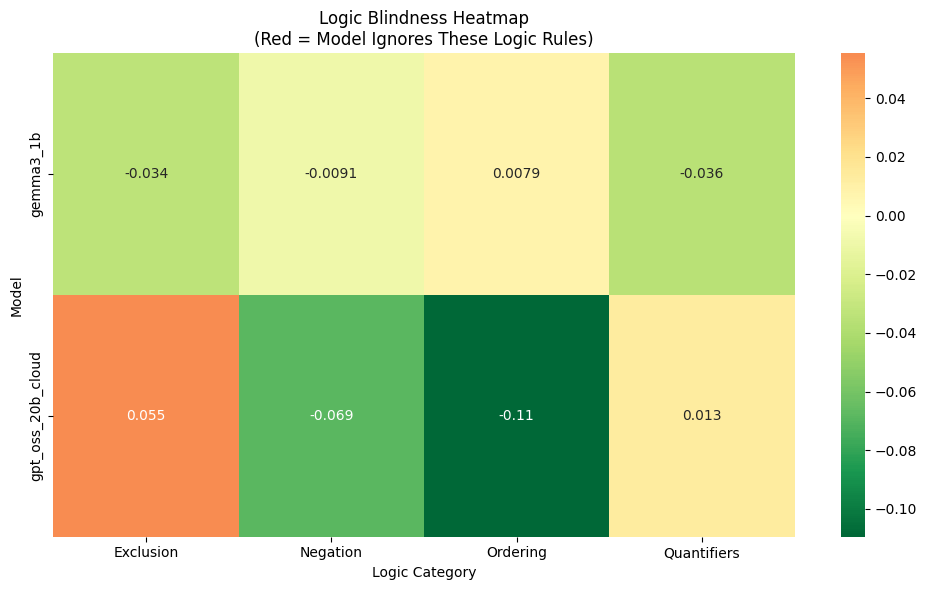


Detailed logic breakdown saved to 'eval_logic_breakdown.csv'


In [ ]:
# 1. CONFIGURATION & DATA LOADING
# .......................................................................................................................................................... #
FILE_PATH = "eval_ollama_results.pkl"                   # path to the pickle file containing evaluation results
# MODELS = ["gemma3:1b", "gpt-oss:20b-cloud"]           # models we used
MODELS = ["gemma3_1b", "gpt_oss_20b_cloud"]             # normalized names of models

# dictionary defining logic categories and their associated keywords
LOGIC_GROUPS = {
    "Negation": ["not", "never", "no", "neither", "none"],                            # words of negation
    "Exclusion": ["except", "unless", "excluding", "without"],                        # words for exlcusion
    "Quantifiers": ["all", "every", "some", "exactly", "only"],                       # words related to quantities
    "Ordering": ["before", "after", "next", "behind", "first", "last"]                # words related to orders and sequence
}

# loading evaluation data from the pickle file into a dataframe
df = pd.read_pickle(FILE_PATH)

# .......................................................................................................................................................... #
# 2. TAGGING FUNCTIONS
# .......................................................................................................................................................... #
def check_keywords(text, keywords):
    """Returns True if any keyword is found in the text (case-insensitive)."""
    text = str(text).lower()                                                           # convert text to lowercase for consistent matching
    # checking if any of the keywords exist in the text string
    return any(k in text for k in keywords)

# looping through each logic group to tag rows containing specific logic types
for group_name, keywords in LOGIC_GROUPS.items():
    col_name = f"has_{group_name}"                                                # defining column name for the boolean flag
    # applying the "check_keywords" function to combined text and questions
    df[col_name] = df.apply(lambda x: check_keywords(x['text'] + " " + x['question'], keywords), axis=1)

# flattening list of all keywords to analyze individual word impacts
all_keywords = [w for words in LOGIC_GROUPS.values() for w in words]

# looingp through every individual keyword to tag its presence in the text
for word in all_keywords:
    # creating a column for each specific word (e.g., has_word_not)
    df[f"has_word_{word}"] = df.apply(lambda x: check_keywords(x['text'] + " " + x['question'], [word]), axis=1)

# .......................................................................................................................................................... #
# 3. ANALYSIS LOGIC
# .......................................................................................................................................................... #
report_rows = []                                                  # empty initialization of a list to store dictionary results 

# iterating for each model as mentioned in configuration above in Part 1
for model in MODELS:    
    # identify all columns relevant to the current model that contain answers
    # filtering by columns starting with model name and ending with '_ans'
    valid_cols = [c for c in df.columns if c.startswith(model) and c.endswith("_ans")]
    
    # iterating through each specific result column (each combination of prompt and tone)
    for col in valid_cols:
        # extracting Prompt/Tone from column name
        # out-col format: "model_pType_tone_ans"
        parts = col.split("_")
        p_type = parts[-3]                      # zs, fs, cot
        tone = parts[-2]                        # neutral, urgent etc.
        
        # convert actual answers to numeric, handling errors by coercing to NaN
        actual = pd.to_numeric(df['answer'], errors='coerce')
        pred = pd.to_numeric(df[col], errors='coerce')          # # convert model predictions to numeric, handling errors
        is_correct = (pred == actual)                           # # create a boolean series: true if prediction matches actual, false otherwise
        
        #..........A) GROUP ANALYSIS...........
        # analyze performance based on broad logic groups (negation, exclusion, etc.)
        for group_name in LOGIC_GROUPS.keys():
            mask = df[f"has_{group_name}"]                         # boolean mask identifying rows containing terms from the current group
            acc_with = is_correct[mask].mean()                     # calculate accuracy for puzzles containing the logic term
            acc_without = is_correct[~mask].mean()                 # calculate accuracy for puzzles NOT containing the logic term
            
            # appending results to the report list
            report_rows.append({
                "Model": model,                                    # model name
                "Prompt": p_type,                                  # promt type
                "Tone": tone,                                      # tone used
                "Type": "Group",                                   # Group analysis just naming it
                "Term": group_name,                                # the specific logic category
                "Count": mask.sum(),                               # number of samples with this term
                "Acc_With_Term": acc_with,                         # performance when term is present
                "Acc_Without_Term": acc_without,                   # performance when term is absent
                "Impact_Gap": acc_without - acc_with               # Positive = Model struggles with this group
            })

        # ..........B) INDIVIDUAL WORD ANALYSIS ..........
        # analyze performance for specific keywords to find specific failure points
        for word in all_keywords:
            mask = df[f"has_word_{word}"]                          # boolean mask for the specific word
            if mask.sum() < 3: continue                            # Skip words that appear rarely (noise)
            
            # calculate accuracy with and without the specific word
            acc_with = is_correct[mask].mean()
            acc_without = is_correct[~mask].mean()
            
            # append word-level results
            report_rows.append({
                "Model": model,
                "Prompt": p_type,
                "Tone": tone,
                "Type": "Word",                                     # distinguishing this as a word-level stats
                "Term": word,                                       # the specific word
                "Count": mask.sum(),
                "Acc_With_Term": acc_with,
                "Acc_Without_Term": acc_without,
                "Impact_Gap": acc_without - acc_with
            })

# .......................................................................................................................................................... #
# 4. Report generation
# .......................................................................................................................................................... #
# convert the list of dictionaries into a pandas dataframe
results = pd.DataFrame(report_rows)

#.....................................................................
# ....................................................................
print("\n ====== TOP LOGIC WEAKNESSES (High Impact Gap) ====== ")

# filter dataset to look only at group-level stats
group_res = results[results["Type"] == "Group"]

# aggregate stats by model and term (averaging across prompt types/tones)
# sort descending by 'Impact_Gap' to highlight biggest weaknesses first
summary = group_res.groupby(["Model", "Term"])[["Acc_With_Term", "Impact_Gap"]].mean().sort_values("Impact_Gap", ascending=False)
print(summary)      # Output of Stats

# ....................................................................
# ....................................................................
print("\n ====== SPECIFIC WORD FAILURES ====== ")
word_res = results[results["Type"] == "Word"]                                                        # # filter dataset to look only at word-level stats
word_summary = word_res.groupby(["Model", "Term"])[["Count", "Acc_With_Term", "Impact_Gap"]].mean()  # # aggregate stats by model and word

# filter for significant failures where the gap is greater than 10%
# sort descending to show worst words first
print(word_summary[word_summary["Impact_Gap"] > 0.10].sort_values("Impact_Gap", ascending=False))

# .......................................................................................................................................................... #
# 5. VISUALIZATION (Heatmap)
# .......................................................................................................................................................... #
# Visualizing the "Impact Gap" for Logic Groups
# Pivoting data for heatmap: Rows=Model, Cols=Logic Group, Values=Impact Gap
# Setting up the matplotlib figure size
plt.figure(figsize=(10, 6))
pivot_table = group_res.groupby(["Model", "Term"])["Impact_Gap"].mean().unstack()     # # pivot data for heatmap:
sns.heatmap(pivot_table, annot=True, cmap="RdYlGn_r", center=0)                       # creating heatmap using seaborn
# cmap="RdYlGn_r" reverses the red-green scale so red indicates high positive gap (bad performance)


# chart titles and labels
plt.title("Logic Blindness Heatmap\n(Red = Model Ignores These Logic Rules)")
plt.ylabel("Model")
plt.xlabel("Logic Category")
plt.tight_layout()
plt.show()

# saving the detailed CSV file
results.to_csv("eval_logic_breakdown.csv", index=False)
print("\nDetailed logic breakdown saved to 'eval_logic_breakdown.csv'")

##### Part 3) Zero-Shot & Neutral Tone Prompt Case analysis for specific logical words on puzzles

In [ ]:
# Zero-Shot Neutral Tone Prompt Case Analysis for Specific Logical words on puzzles
# ................................................................................................................................ #

# ................................................................................................................................ #
# 1) CONFIGURATION
# ................................................................................................................................ #
INPUT_FILE = "eval_ollama_results.pkl"                                # file saved with ollama results is loaded
OUTPUT_FILE = "eval_ablation_results_zs.csv"                          # output file with the results of analysis
MODELS = ["gemma3:1b", "gpt-oss:20b-cloud"]                           # models used

# Logical groups to be tested
LOGIC_GROUPS = {
    "Negation": ["not", "never", "no", "neither", "none"],
    "Exclusion": ["except", "unless", "excluding", "excluded", "without"],
    "Quantifiers": ["all", "every", "some", "exactly", "exact", "only"],
    "Ordering": ["before", "after", "next", "first", "last"]
}
# reading the file and loading into dataframe
print(f"Loading data from {INPUT_FILE}...")
df = pd.read_pickle(INPUT_FILE)

# ................................................................................................................................ #
# 2. Functions Used    - remove keywords & - building prompt
# ................................................................................................................................ #
def remove_keywords(text, keywords):
    """
    Removes specific keywords from text to test model dependency.
    Example: "A is not B" -> "A is  B"
    """
    modified_text = str(text)
    for word in keywords:
        # regex: \b matches word boundaries to avoid partial matches for no or not or nothing etc.
        # case insensitive replacement with a single space
        pattern = r'\b' + re.escape(word) + r'\b'
        modified_text = re.sub(pattern, ' ', modified_text, flags=re.IGNORECASE)
    
    # cleaning up double spaces created by removal to keep hte text normal
    return re.sub(r'\s+', ' ', modified_text).strip()

# zero-shot prompt builder and using neutral tone
def build_zs_prompt(text, question, options):
    return f"""Solve the puzzle clearly and choose the correct option. Return ONLY the option number. Do not explain.

Puzzle:
{text}

Question:
{question}

Options:
{options}

Answer:"""

# ................................................................................................................................ #
# 3. ABLATION LOOP
# ................................................................................................................................ #
results = []                                                                            # list to store the results of the experiment

print(" ====== Starting Counterfactual (Ablation) Analysis ====== ")
print(" ====== Removing logical words to see if the model notices  ====== ")

# iterating through each logic group (e.g., negation, quantifiers)
for group_name, keywords in LOGIC_GROUPS.items():
    print(f"\nAnalyzing Group: {group_name}...")
    
    # 1. Filtering puzzles that "have" these words
    # combining text+question for the check
    mask = df.apply(lambda x: any(k in (str(x['text']) + " " + str(x['question'])).lower() for k in keywords), axis=1)
    
    target_df = df[mask].copy()           # copy of the subset of data
    
    print(f"Found {len(target_df)} puzzles containing '{group_name}' terms.")
    
    # iterating through each puzzle in this subset
    for idx, row in target_df.iterrows():
        # 2. create ablated text (remove the critical logic words)
        ablated_text = remove_keywords(row['text'], keywords)
        ablated_question = remove_keywords(row['question'], keywords)
        
        # build the new prompt with the broken text
        prompt = build_zs_prompt(ablated_text, ablated_question, row['options'])
        

        for model in MODELS:
            # Get the "ORIGINAL" answer from previous run for comparison
            # here using zero-shot only 
            safe_model = model.replace(":", "_").replace("-", "_")
            col_orig = f"{safe_model}_zs_neutral_ans"
            
            original_ans = row[col_orig]
            
            # skip if the model originally got it wrong or errored out. 
            # rationale: if the model didn't understand the full puzzle, its useless to measure if removing a word "broke" its reasoning
            if pd.isna(original_ans) or original_ans == "ERROR":
                continue

            try:
                # 3. running inference on the ablated text
                response = ollama.chat(model=model, messages=[{'role': 'user', 'content': prompt}])
                content = response['message']['content']
                
                # extracting answer using regex
                clean_txt = content.replace("*", "").replace("#", "")
                ablated_ans = None

                match = re.search(r"Final Answer:?\s*(\d+)", clean_txt, re.IGNORECASE)     # # attempt to find "final answer: x" pattern
                if match:
                    ablated_ans = int(match.group(1))
                else:
                    digits = re.findall(r"\b(\d+)\b", clean_txt)         # # fallback: find the last number in the text
                    if digits: ablated_ans = int(digits[-1])
                
                # 4. Analyzing Impact
                # checking if answer changed after removing the word
                # changed = false -> model ignored the word
                # changed = true -> model was sensitive
                changed = (ablated_ans != original_ans)
                
                # storing the results
                results.append({
                    "id": idx,
                    "Model": model,
                    "Logic_Group": group_name,
                    "Original_Ans": original_ans,
                    "Ablated_Ans": ablated_ans,
                    "Did_Answer_Change": changed,
                    "True_Answer": row['answer']
                })
                
                # statemetn for debugging..commented out after I ran the whole set
                # print(f"Pz {idx} | {model} | Removed {group_name} -> Changed? {changed} (Orig: {original_ans} vs New: {ablated_ans})")

            except Exception as e:
                # logging errors if any
                print(f"Error on {model} {idx}: {e}")

# ................................................................................................................................ #
# 4. Summary Stats
# ................................................................................................................................ #
res_df = pd.DataFrame(results)          # converting the list of dictionary to  dataframe

print("\n\n ====== Ablation (Countrefactuals) Result Summary ====== ")
print("Interpretation: High 'Change Rate' is GOOD, meaning the the model noticed that the word was missing.")
print("Low 'Change Rate' (near 0%) means the model ignores the logic words (thus model is biased).")


# group by model and logic category to calculate sensitivity
summary = res_df.groupby(["Model", "Logic_Group"]).agg(
    Total_Tests=('id', 'count'),                                             # # how many puzzles we tested
    Times_Answer_Changed=('Did_Answer_Change', 'sum')                        # # how many times the answer flipped
)
summary['Sensitivity_Score (%)'] = (summary['Times_Answer_Changed'] / summary['Total_Tests']) * 100           # sensitivity score as a percentage

print(summary)

# save the detailed results to csv
res_df.to_csv(OUTPUT_FILE, index=False)
print(f"\nDetailed ablation results saved to {OUTPUT_FILE}")

Loading data from eval_ollama_results.pkl...
 ====== Starting Counterfactual (Ablation) Analysis ====== 
 ====== Removing logical words to see if the model notices  ====== 

Analyzing Group: Negation...
Found 53 puzzles containing 'Negation' terms.

Analyzing Group: Exclusion...
Found 14 puzzles containing 'Exclusion' terms.

Analyzing Group: Quantifiers...
Found 43 puzzles containing 'Quantifiers' terms.

Analyzing Group: Ordering...
Found 16 puzzles containing 'Ordering' terms.


 ====== Ablation (Countrefactuals) Result Summary ====== 
Interpretation: High 'Change Rate' is GOOD, meaning the the model noticed that the word was missing.
Low 'Change Rate' (near 0%) means the model ignores the logic words (thus model is biased).
                               Total_Tests  Times_Answer_Changed  \
Model             Logic_Group                                      
gemma3:1b         Exclusion             14                     5   
                  Negation              53                

##### Part 4) Data Visualization

In [3]:
# a) loading dataset
# ................................................................................................................................................................ #
# file paths
pkl_path = "eval_ollama_results.pkl"           # raw data with time/answers
logic_path = "eval_logic_breakdown.csv"        # processed logic group stats
ablation_path = "eval_ablation_results_zs.csv" # sensitivity/ablation stats

# load all datasets
# print("loading datasets...")
df_raw = pd.read_pickle(pkl_path)              # main raw dataframe with results
df_logic = pd.read_csv(logic_path)             # logic performance dataframe
df_ablation = pd.read_csv(ablation_path)       # ablation results dataframe

# model list used
models = ["gemma3:1b", "gpt-oss:20b-cloud"]

# data loaded


 ====== 1. Logic Blindness (Accuracy Gap: Simple vs Complex) ====== 
                 Model         Term  Acc_With_Term  Acc_Without_Term    Gap
151  gpt_oss_20b_cloud    Exclusion          57.14             85.25  28.10
61           gemma3_1b    Exclusion           7.14             26.23  19.09
120          gemma3_1b     Negation          24.53             40.91  16.38
33           gemma3_1b     Ordering          23.53             36.21  12.68
91           gemma3_1b    Exclusion          14.29             24.59  10.30
257  gpt_oss_20b_cloud  Quantifiers          74.42             84.38   9.96
105          gemma3_1b     Negation          26.42             36.36   9.95
121          gemma3_1b    Exclusion          21.43             31.15   9.72
256  gpt_oss_20b_cloud    Exclusion          71.43             80.33   8.90
46           gemma3_1b    Exclusion          14.29             22.95   8.67


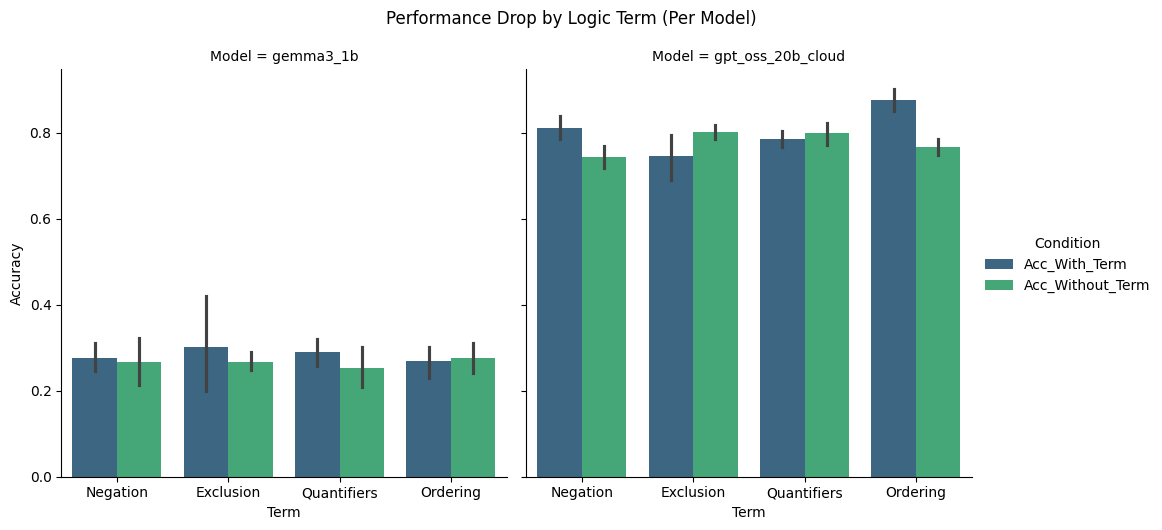

In [4]:
# Chart 1: Performance by logic types
# ................................................................................................................................................................ #

# 1. dataset grouping for each logic type
group_data = df_logic[df_logic["Type"] == "Group"].copy()  # making a copy

# 2. gap calculation
# Gap -> accuracy drop when the logic term is present
group_data["Gap"] = group_data["Acc_Without_Term"] - group_data["Acc_With_Term"]

# 3. Table output
print("\n ====== 1. Logic Blindness (Accuracy Gap: Simple vs Complex) ====== ")

# Sorting by gap to see worst failures first
gap_summary = group_data[["Model", "Term", "Acc_With_Term", "Acc_Without_Term", "Gap"]].sort_values("Gap", ascending=False).head(10)

# Creating a display copy
display_df = gap_summary.copy()
cols_to_multiply = ["Acc_With_Term", "Acc_Without_Term", "Gap"]
display_df[cols_to_multiply] = display_df[cols_to_multiply] * 100

print(display_df.round(2))

# 4. Potting chart
# Reshaping data for plotting
melted = group_data.melt(
    id_vars=["Model", "Term"], 
    value_vars=["Acc_With_Term", "Acc_Without_Term"],
    var_name="Condition", 
    value_name="Accuracy"
)

g = sns.catplot(
    data=melted, 
    kind="bar", 
    x="Term", 
    y="Accuracy", 
    col="Model",
    hue="Condition", 
    palette="viridis", 
    height=5, 
    aspect=1
)

g.figure.suptitle("Performance Drop by Logic Term (Per Model)", y=1.05)
plt.show()


 ====== 1. Category Level: Logic Blindness (e.g., Negation, Ordering) ====== 
               Model         Term  Acc_With_Term  Acc_Without_Term    Gap
4  gpt_oss_20b_cloud    Exclusion          74.60             80.15   5.54
7  gpt_oss_20b_cloud  Quantifiers          78.55             79.86   1.31
2          gemma3_1b     Ordering          26.80             27.59   0.79
1          gemma3_1b     Negation          27.67             26.77  -0.91
0          gemma3_1b    Exclusion          30.16             26.78  -3.38
3          gemma3_1b  Quantifiers          28.94             25.35  -3.59
5  gpt_oss_20b_cloud     Negation          81.13             74.24  -6.89
6  gpt_oss_20b_cloud     Ordering          87.58             76.63 -10.95

 ====== 2. Word Level: Keyword Sensitivity (e.g., 'not', 'never') ====== 
                Model     Term  Acc_With_Term  Acc_Without_Term    Gap
21  gpt_oss_20b_cloud  without          60.32             81.05  20.73
20  gpt_oss_20b_cloud     some        

<Figure size 1200x600 with 0 Axes>

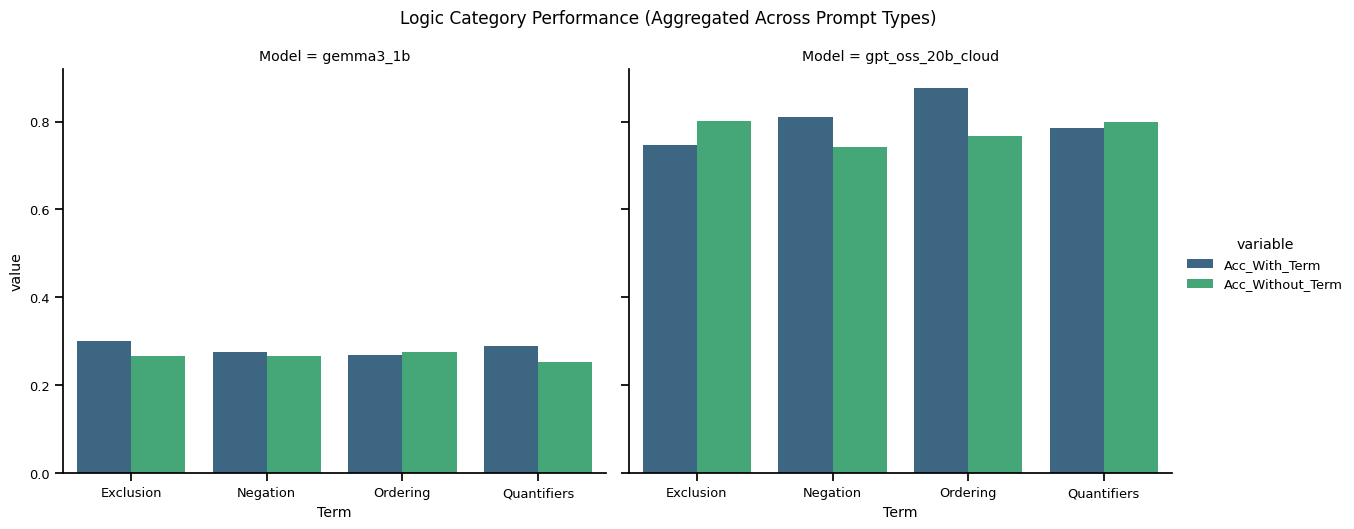

In [ ]:
# Chart 1: Performance by logic types
# ................................................................................................................................................................ #
# 1. Split the data into Group-level and Word-level
group_df = df_logic[df_logic["Type"] == "Group"].copy()
word_df = df_logic[df_logic["Type"] == "Word"].copy()

# 2. Function to aggregate and calculate Gap
def process_logic_level(df, level_name):
    # Aggregate across different prompt types for that specific level
    aggregated = df.groupby(["Model", "Term"]).agg({
        "Acc_With_Term": "mean",
        "Acc_Without_Term": "mean"
    }).reset_index()
    
    aggregated["Gap"] = aggregated["Acc_Without_Term"] - aggregated["Acc_With_Term"]
    return aggregated

# Process both
group_final = process_logic_level(group_df, "Group")
word_final = process_logic_level(word_df, "Word")

# 3. Output Table for Group Level (Categorical Logic)
print("\n ====== 1. Category Level: Logic Blindness (e.g., Negation, Ordering) ====== ")
display_group = group_final.sort_values("Gap", ascending=False).copy()
display_group[["Acc_With_Term", "Acc_Without_Term", "Gap"]] *= 100
print(display_group.round(2).head(10))

# 4. Output Table for Word Level (Specific Keywords)
print("\n ====== 2. Word Level: Keyword Sensitivity (e.g., 'not', 'never') ====== ")
display_word = word_final.sort_values("Gap", ascending=False).copy()
display_word[["Acc_With_Term", "Acc_Without_Term", "Gap"]] *= 100
print(display_word.round(2).head(10))

# 5. Visualization - Focusing on the Group level for the main report
plt.figure(figsize=(12, 6))
melted_group = group_final.melt(id_vars=["Model", "Term"], value_vars=["Acc_With_Term", "Acc_Without_Term"])

g = sns.catplot(
    data=melted_group, kind="bar", 
    x="Term", y="value", col="Model", hue="variable",
    palette="viridis", height=5, aspect=1.2
)
g.figure.suptitle("Logic Category Performance (Aggregated Across Prompt Types)", y=1.05)
plt.show()



 ====== 2. Logic Sensitivity Scores (% of Answers Changed) ====== 
Logic_Group        Exclusion  Negation  Ordering  Quantifiers
Model                                                        
gemma3:1b              35.71     13.21     18.75         6.98
gpt-oss:20b-cloud      57.14     20.75     18.75        20.93


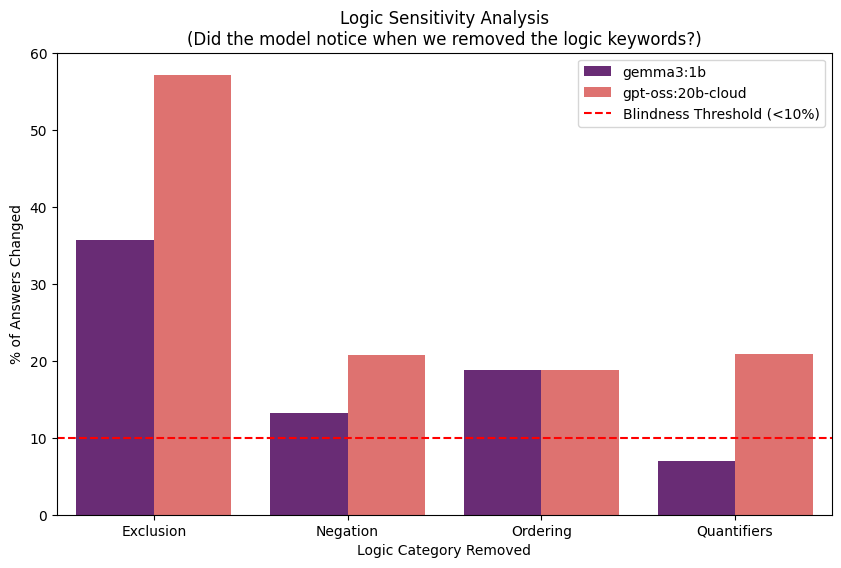

In [5]:
# CHART 2: Sensitivity Score (Substitute for "Z3")
# ................................................................................................................................................................ #

# group by model and logic category
summary_ablation = df_ablation.groupby(["Model", "Logic_Group"]).agg(
    Total=('id', 'count'),
    Changed=('Did_Answer_Change', 'sum')
)

# calculate percentage of changed answers
summary_ablation['Sensitivity_Score'] = (summary_ablation['Changed'] / summary_ablation['Total']) * 100
summary_ablation = summary_ablation.reset_index()

# sensitivity scores
print("\n\n ====== 2. Logic Sensitivity Scores (% of Answers Changed) ====== ")
# Pivot for cleaner reading
sensitivity_pivot = summary_ablation.pivot(
    index="Model", 
    columns="Logic_Group", 
    values="Sensitivity_Score"
)
print(sensitivity_pivot.round(2))

# plot setup
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_ablation, x="Logic_Group", y="Sensitivity_Score", hue="Model", palette="magma")

# add threshold line
plt.axhline(y=10, color='r', linestyle='--', label="Blindness Threshold (<10%)")

# titles
plt.title("Logic Sensitivity Analysis\n(Did the model notice when we removed the logic keywords?)")
plt.ylabel("% of Answers Changed")
plt.xlabel("Logic Category Removed")
plt.legend()
plt.show()



 ====== 3. Chain-of-Thought Gain (CoT vs ZS Baseline) ====== 
                   Gain
Model                  
gemma3_1b         -12.0
gpt_oss_20b_cloud   0.0


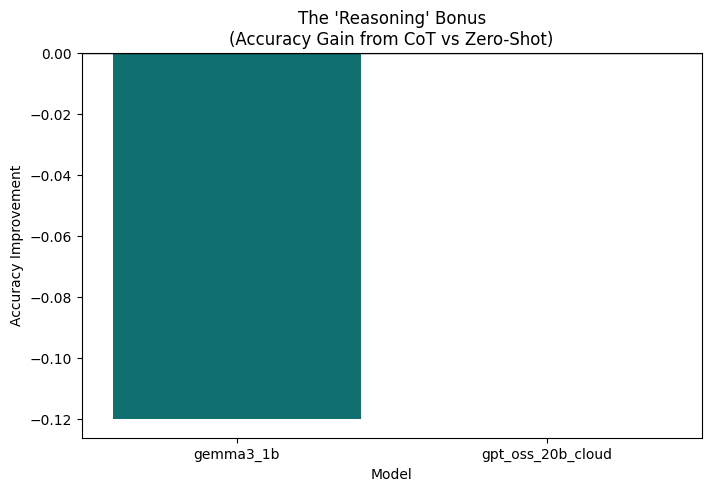

In [6]:
# Chart 3. CoT Gain
# ................................................................................................................................................................ #

# extract model names dynamically from columns
model_prefixes = [col.split("_zs_")[0] for col in df_raw.columns if "_zs_neutral_ans" in col]
cot_gain_rows = []

# looping for model-prefixes/ names
for model in model_prefixes:
    # define columns
    zs_col = f"{model}_zs_neutral_ans"
    cot_col = f"{model}_cot_neutral_ans"
    
    # calculating accuracy
    zs_acc = (df_raw[zs_col] == df_raw['answer']).mean()
    cot_acc = (df_raw[cot_col] == df_raw['answer']).mean()
    
    # gain for cot
    cot_gain_rows.append({
        "Model": model,
        "Gain": cot_acc - zs_acc
    })

gain_df = pd.DataFrame(cot_gain_rows)  # converting to data frame

# 3. COT GAIN (The numbers for the Reasoning Bonus Chart)
print("\n\n ====== 3. Chain-of-Thought Gain (CoT vs ZS Baseline) ====== ")
print(gain_df.set_index("Model").round(4) * 100)

# plotting the results
plt.figure(figsize=(8, 5))
sns.barplot(data=gain_df, x="Model", y="Gain", color="teal")
plt.axhline(0, color='black', linewidth=1) # baseline
plt.title("The 'Reasoning' Bonus\n(Accuracy Gain from CoT vs Zero-Shot)")
plt.ylabel("Accuracy Improvement")
plt.show()


 ====== 4. Performance Matrix (Accuracy by Prompt & Tone) ====== 
Prompt                            zs     fs    cot
Model             Tone                            
gemma3:1b         high_stakes  33.33  24.00  29.33
                  neutral      34.67  21.33  22.67
                  urgent       29.33  22.67  29.33
gpt-oss:20b-cloud high_stakes  77.33  76.00  78.67
                  neutral      81.33  81.33  81.33
                  urgent       80.00  80.00  76.00


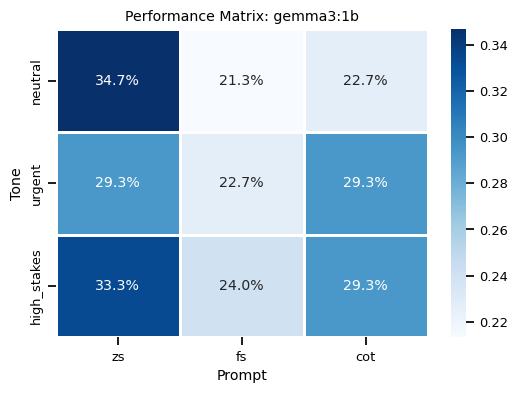

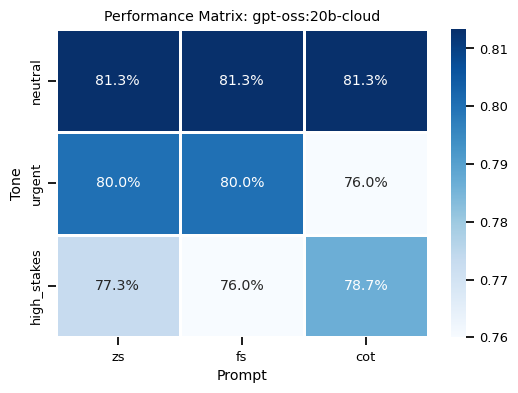

In [7]:
# Chart 4: Heatmaps for performance matrix
# ................................................................................................................................................................ #
prompt_types = ["zs", "fs", "cot"]
tones = ["neutral", "urgent", "high_stakes"]
matrix_rows = []

# 1(a). aggregating data
for model in models:
    safe_model = model.replace(":", "_").replace("-", "_")
    for p in prompt_types:
        for t in tones:
            col = f"{safe_model}_{p}_{t}_ans"
            if col in df_raw.columns:
                acc = (df_raw[col] == df_raw['answer']).mean()
                matrix_rows.append({"Model": model, "Prompt": p, "Tone": t, "Accuracy": acc})

perf_matrix = pd.DataFrame(matrix_rows)


# 1(b). Performance matrix (table)
print("\n ====== 4. Performance Matrix (Accuracy by Prompt & Tone) ====== ")
# Pivot to make it readable like the heatmap
matrix_pivot = perf_matrix.pivot_table(
    index=["Model", "Tone"], 
    columns="Prompt", 
    values="Accuracy"
)
# Reorder for logic
matrix_pivot = matrix_pivot.reindex(columns=["zs", "fs", "cot"], level="Tone")
print(matrix_pivot.round(4) * 100) # Print as percentages


# 2. plotting heatmaps for each model
sns.set_context("notebook", font_scale=0.85)

for model in models:
    # pivot data for heatmap structure
    data = perf_matrix[perf_matrix["Model"] == model]
    heatmap_data = data.pivot(index="Tone", columns="Prompt", values="Accuracy")
    
    # reorder for logic
    heatmap_data = heatmap_data.reindex(index=["neutral", "urgent", "high_stakes"], 
                                        columns=["zs", "fs", "cot"])
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(heatmap_data, annot=True, fmt=".1%", cmap="Blues", linewidths=1)
    plt.title(f"Performance Matrix: {model}")
    plt.show()



=== 5. Time Analysis (Avg Seconds per Tone) ===
Tone               neutral  urgent  Speedup_%
Model                                        
gemma3:1b             1.56    1.24      20.47
gpt-oss:20b-cloud    11.33   10.42       8.01


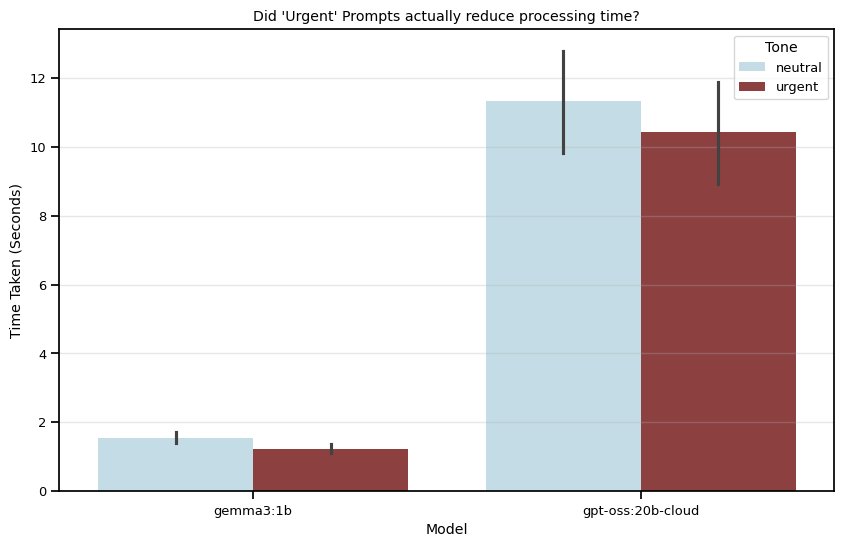

In [8]:
# Chart 5: Time analysis for neutral vs urgent tones
# ....................................................................................................................................................................... # 
time_data = []

# 1. extracting time data
for model in models:
    safe_model = model.replace(":", "_").replace("-", "_")
    for tone in ["neutral", "urgent"]:
        # aggregate time across all prompt types for this tone
        for p in ["zs", "fs", "cot"]:
            col = f"{safe_model}_{p}_{tone}_time"
            if col in df_raw.columns:
                times = df_raw[col].dropna()
                for t in times:
                    time_data.append({"Model": model, "Tone": tone, "Time": float(t)})

time_df = pd.DataFrame(time_data)

# table output
print("\n\n=== 5. Time Analysis (Avg Seconds per Tone) ===")
time_summary = time_df.groupby(["Model", "Tone"])["Time"].mean().unstack()
# Calculate speedup percentage
time_summary["Speedup_%"] = ((time_summary["neutral"] - time_summary["urgent"]) / time_summary["neutral"]) * 100
print(time_summary.round(2))

# 2. plotting data
plt.figure(figsize=(10, 6))
sns.barplot(
    data=time_df, 
    x="Model", 
    y="Time", 
    hue="Tone", 
    palette={"neutral": "lightblue", "urgent": "maroon"}, 
    alpha=0.8
)

plt.title("Did 'Urgent' Prompts actually reduce processing time?")
plt.ylabel("Time Taken (Seconds)")
plt.grid(axis='y', alpha=0.3)
plt.show()

##### Part 5) Comaprison of Neutral Tone of ZS vs COT of GPT Model 

Comparing: gpt_oss_20b_cloud_zs_neutral_ans vs gpt_oss_20b_cloud_cot_neutral_ans

 ====== Divergence Analysis ====== 
Robust (Both Right): 57 Puzzles
Hard (Both Wrong): 10 Puzzles
ZS Only (Overthinking?): 4 Puzzles
CoT Only (Reasoning Gain): 4 Puzzles

Disagreement Rate: 8/75 (10.7%)
Even though net accuracy is similar, the model changed its mind on this many puzzles.


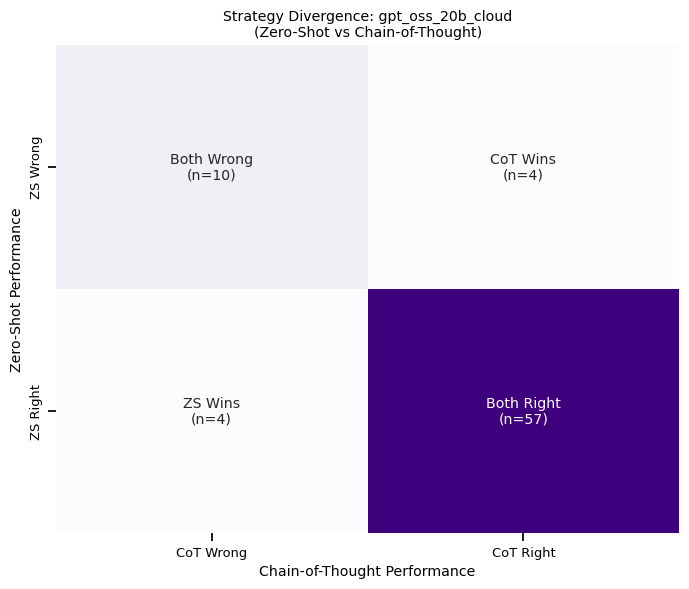



 ====== Examples: Where ZERO-SHOT Won (CoT kept Overthinking?) ====== 

[Puzzle ID 18]
--------------------
Text:
Anthropologists measured human skulls at various periods in history and found that the average brain capacity of contemporary adults is 1349
milliliters, compared with the brain capacity of Mesolithic humans, the brain capacity of men is reduced by 10%. The brain capacity of women is
reduced by 17%. The researchers believe that in an era of increasingly clear division of labor, people with a cooperative spirit have more
opportunities to survive and reproduce than others, and survival of the friendliest is an important reason for the shrinking human brain.
--------------------
Question:       Which of the following options, if true, best supports the above conclusion?
Options:
  0. "Contemporary brain science research shows that a smaller brain capacity makes humans more cooperative.",
  1. "Cooperation will reduce human aggressiveness, and the reduction of aggressiveness 

In [25]:
# Comaprison of Neutral Tone for ZS & CoT for GPT model
import textwrap  # for text wrap

# Define the specific model and tone to compare
model_key = "gpt_oss_20b_cloud"  # Ensure this matches your column naming convention
tone = "neutral"

# Constructing column names
col_zs = f"{model_key}_zs_{tone}_ans"
col_cot = f"{model_key}_cot_{tone}_ans"
col_truth = "answer"

print(f"Comparing: {col_zs} vs {col_cot}")

# ==========================================
# 2. Classification of Puzzles
# ==========================================
# Create boolean masks for correctness
zs_correct = (df_raw[col_zs] == df_raw[col_truth])
cot_correct = (df_raw[col_cot] == df_raw[col_truth])

# Create the 4 Categories
both_right = zs_correct & cot_correct
both_wrong = (~zs_correct) & (~cot_correct)
zs_wins = zs_correct & (~cot_correct)   # ZS Right, CoT Wrong
cot_wins = (~zs_correct) & cot_correct  # CoT Right, ZS Wrong

# Storing counts
categories = {
    "Robust (Both Right)": both_right.sum(),
    "Hard (Both Wrong)": both_wrong.sum(),
    "ZS Only (Overthinking?)": zs_wins.sum(),
    "CoT Only (Reasoning Gain)": cot_wins.sum()
}

print("\n ====== Divergence Analysis ====== ")
for cat, count in categories.items():
    print(f"{cat}: {count} Puzzles")

# Calculating "Churn" (How many puzzles changed status?)
disagreement = zs_wins.sum() + cot_wins.sum()
total = len(df_raw)
print(f"\nDisagreement Rate: {disagreement}/{total} ({disagreement/total:.1%})")
print("Even though net accuracy is similar, the model changed its mind on this many puzzles.")

# ......................................................................................................................................................... # 
# 3. Visualization: Agreement Matrix
# ......................................................................................................................................................... # 
# Creating a 2x2 matrix for a heatmap, like confusion matrix
# Rows = Zero Shot Status, Cols = CoT Status
matrix_data = [
    [both_wrong.sum(), cot_wins.sum()],   # Row 0: ZS Wrong
    [zs_wins.sum(), both_right.sum()]     # Row 1: ZS Right
]

plt.figure(figsize=(7, 6))
sns.set_context("notebook", font_scale=0.85)

# Annotations to make the chart readable
labels = [
    [f"Both Wrong\n(n={both_wrong.sum()})", f"CoT Wins\n(n={cot_wins.sum()})"],
    [f"ZS Wins\n(n={zs_wins.sum()})", f"Both Right\n(n={both_right.sum()})"]
]

# heatmap
sns.heatmap(
    matrix_data, 
    annot=labels, 
    fmt="", 
    cmap="Purples", 
    cbar=False,
    xticklabels=["CoT Wrong", "CoT Right"],
    yticklabels=["ZS Wrong", "ZS Right"]
)

plt.title(f"Strategy Divergence: {model_key}\n(Zero-Shot vs Chain-of-Thought)")
plt.xlabel("Chain-of-Thought Performance")
plt.ylabel("Zero-Shot Performance")
plt.tight_layout()
plt.show()

# ...............................................................................................
# 4. Lookipng at puzzles 
# ...............................................................................................

wrapper = textwrap.TextWrapper(width=80, break_long_words=False, replace_whitespace=False)

# Puzzles with disagreement
print("\n\n ====== Examples: Where ZERO-SHOT Won (CoT kept Overthinking?) ====== ")
zs_win_indices = df_raw[zs_wins].index.tolist()[:4]

for idx in zs_win_indices:
    row = df_raw.loc[idx]
    print(f"\n" + "="*80)
    print(f"[Puzzle ID {idx}]")
    print("-" * 20)
    # Wrap the Puzzle Text
    print("Text:")
    print(textwrap.fill(str(row['text']), width=150))
    print("-" * 20)
    print(f"Question:       {row['question']}")
    # Wrap Options 
    print("Options:")
    raw_options = str(row['options'])
    
    # Splitting by numbered patterns like "0. ", "1. ", "2. "
    # regex looking for a number followed by a dot and space (e.g., "1. ")
    split_options = re.split(r'(?=\d+\.\s)', raw_options)
    
    for opt in split_options:
        if opt.strip():             # Skip empty strings if any
            # Wrapping each option individually
            print(textwrap.fill(opt.strip(), width=150, initial_indent="  ", subsequent_indent="     "))
    print("-" * 20)
    print(f"Correct Answer: {row['answer']}")
    print(f"ZS Answer:      {row[col_zs]} (CORRECT)")
    print(f"CoT Answer:     {row[col_cot]} (WRONG)")

print("\n\n" + "="*80)
print("=== Examples: Where CoT Won (Reasoning Paid Off?) ===")
print("="*80)

print("\n\n=== Examples: Where CoT Won (Finally Reasoning Paid Off ?) ===")
cot_win_indices = df_raw[cot_wins].index.tolist()[:4]
for idx in cot_win_indices:
    row = df_raw.loc[idx]
    print(f"\n" + "-"*80)
    print(f"[Puzzle ID {idx}]")
    
    # Wrap the Puzzle Text
    print("Text:")
    print(textwrap.fill(str(row['text']), width=150))
    
    print(f"\nQuestion:       {row['question']}")
    
    # --- Options ---
    print("Options:")
    raw_options = str(row['options'])
    
    # Split by numbered patterns like "0. ", "1. ", "2. "
    split_options = re.split(r'(?=\d+\.\s)', raw_options)
    
    for opt in split_options:
        if opt.strip(): # Skip empty strings
            # Wrapping each option individually
            print(textwrap.fill(opt.strip(), width=150, initial_indent="  ", subsequent_indent="     "))
    
    print("-" * 20)
    print(f"Correct Answer: {row['answer']}")
    print(f"ZS Answer:      {row[col_zs]} (WRONG)")
    print(f"CoT Answer:     {row[col_cot]} (CORRECT)")

##### .............................................................................................................. End of Analysis .............................................................................................................. 